In [1]:
import mint
import numpy
import netCDF4

In [2]:
src_grid = mint.Grid()
# required for the cube-sphere grid
src_grid.setFlags(fixLonAcrossDateline=1, averageLonAtPole=1)
src_grid.loadFromUgrid2D('../../data/lfric_diag_wind.nc$Mesh2d')
src_grid.dump('src_grid.vtk')
num_bad_cells = src_grid.check()
print(f'num bad cells = {num_bad_cells}')
mint.writeLogMessages('log.txt')

num bad cells = 0


In [3]:
# get the velocities
nc = netCDF4.Dataset('../../data/lfric_diag_wind.nc')
u1 = nc.variables['u1'][:]
u2 = nc.variables['u2'][:]

In [4]:
# compute integrals of the velocity over the edges (flows)
lon = nc.variables['Mesh2d_node_x']
lat = nc.variables['Mesh2d_node_y']
edge_node_connect = nc.variables['Mesh2d_edge_nodes']
ibeg = edge_node_connect[:, 0]
iend = edge_node_connect[:, 1]

lonbeg = lon[ibeg]
lonend = lon[iend]
lonmid = (lonbeg + lonend)*0.5

latbeg = lat[ibeg]
latend = lat[iend]
latmid = (latbeg + latend)*0.5

nedge = lonbeg.shape[0]
deg2rad = numpy.pi/180.

ds = numpy.zeros((nedge, 2), numpy.float64)
ds[:, 0] = lonend - lonbeg
ds[:, 1] = latend - latbeg

rhobeg = numpy.cos(latbeg*deg2rad)
xyzbeg = numpy.zeros((nedge, 3), numpy.float64)
xyzbeg[:, 0] = rhobeg * numpy.cos(lonbeg*deg2rad)
xyzbeg[:, 1] = rhobeg * numpy.sin(lonbeg*deg2rad)
xyzbeg[:, 2] = numpy.sin(latbeg*deg2rad)

rhoend = numpy.cos(latend*deg2rad)
xyzend = numpy.zeros((nedge, 3), numpy.float64)
xyzend[:, 0] = rhobeg * numpy.cos(lonend*deg2rad)
xyzend[:, 1] = rhobeg * numpy.sin(lonend*deg2rad)
xyzend[:, 2] = numpy.sin(latend*deg2rad)

lambda_hat = numpy.zeros((nedge, 3), numpy.float64)
lambda_hat[:, 0] = - numpy.sin(lonmid*deg2rad)
lambda_hat[:, 1] = numpy.cos(lonmid*deg2rad)

theta_hat = numpy.zeros((nedge, 3), numpy.float64)
theta_hat[:, 0] = - numpy.sin(latmid*deg2rad) * numpy.cos(lonmid*deg2rad)
theta_hat[:, 1] = - numpy.sin(latmid*deg2rad) * numpy.sin(lonmid*deg2rad)
theta_hat[:, 2] = numpy.cos(latmid*deg2rad)

xyzdiff = xyzend - xyzbeg

In [5]:
print(f'min/max of lons: {min(lon)}/{max(lon)}')

min/max of lons: -174.375/180.0


In [6]:
print(xyzdiff.shape)

(3072, 3)


In [42]:
ue_integrated = numpy.zeros(u1.shape, numpy.float64)
uvec = numpy.zeros((nedge, 3), numpy.float64)
for i0 in range(u1.shape[0]):
    for i1 in range(u1.shape[1]):
        for k in range(3):
            uvec[:, k] = u1[i0, i1, :]*lambda_hat[:, k] + u2[i0, i1, :]*theta_hat[:, k]
            # debug
            #uvec[:, k] = lambda_hat[:, k]
        ue_integrated[i0, i1, :] = numpy.sum(uvec*xyzdiff, axis=1)

In [43]:
ue_integrated2 = numpy.zeros(u1.shape, numpy.float64)
for i0 in range(u1.shape[0]):
    for i1 in range(u1.shape[1]):
        ue_integrated2[i0, i1, :] = u1[i0, i1, :]*ds[:, 0] + u2[i0, i1]*ds[:, 1]
        # debug
        #ue_integrated2[i0, i1, :] = ds[:, 0]

In [44]:
# create target grid
llon, llat = numpy.meshgrid(numpy.linspace(-180., 180., 20), numpy.linspace(-80., 80., 10))
ntarget = llon.shape[0] * llon.shape[1]
target_points = numpy.zeros((ntarget, 3), numpy.float64)
target_points[:, 0] = llon.flat
target_points[:, 1] = llat.flat

In [45]:
# create a vector interpolator
vi = mint.VectorInterp()
vi.setGrid(src_grid)
vi.buildLocator(numCellsPerBucket=10)
vi.findPoints(target_points, tol2=1.e-10)
edgeVectors = vi.getEdgeVectorsFromUniqueEdgeData(ue_integrated)
edgeVectors2 = vi.getEdgeVectorsFromUniqueEdgeData(ue_integrated2)

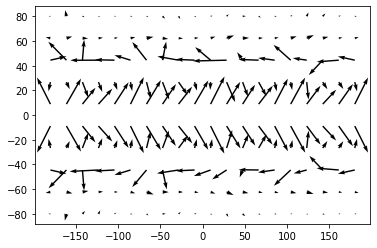

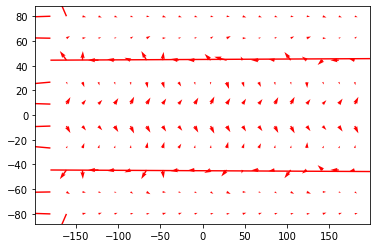

In [47]:
from matplotlib import pylab
pylab.quiver(target_points[:, 0], target_points[:, 1], edgeVectors[:, 0], edgeVectors[:, 1])
pylab.show()

pylab.quiver(target_points[:, 0], target_points[:, 1], edgeVectors2[:, 0], edgeVectors2[:, 1], color='r')
pylab.show()

In [13]:
min(latmid), max(latmid)

(-87.1875, 87.1875)